<a href="https://colab.research.google.com/github/kopachsvitlana/ecommerce_sales_analytics/blob/main/E_Commerce_Sales_Analytics_SQL_Python_%26_Tableau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Встановлення бібліотеки
!pip install --upgrade google-cloud-bigquery

In [ ]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import spearmanr
from itertools import combinations
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
# Авторизація у Google
auth.authenticate_user()

In [ ]:
# Налаштування проєкту BigQuery
project_id = "data-analytics-mate"
client = bigquery.Client(project=project_id)

In [ ]:
query = """
select s.date
       , s.ga_session_id
       , sp.continent
       , sp.country
       , sp.device
       , sp.browser
       , sp.mobile_model_name
       , sp.operating_system
       , sp.language
       , sp.channel
       , acs.account_id
       , ac.is_verified
       , ac.is_unsubscribed
       , p.category
       , p.name
       , p.price
       , p.short_description
from `DA.session` s
left join `DA.session_params`sp on s.ga_session_id=sp.ga_session_id
left join `DA.account_session`acs on s.ga_session_id=acs.ga_session_id
left join `DA.account` ac on acs.account_id=ac.id
left join `DA.order`o on s.ga_session_id=o.ga_session_id
left join `DA.product`p on o.item_id=p.item_id
"""

In [ ]:
query_job = client.query(query)  # Виконання SQL-запиту
results = query_job.result()  # Очікування завершення запиту

In [ ]:
# Створення DataFrame
df = results.to_dataframe()
df.head()


,date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,channel,account_id,is_verified,is_unsubscribed,category,name,price,short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,zh,Paid Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,en-us,Organic Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,zh,Direct,<NA>,<NA>,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,es-es,Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,en-us,Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   channel            349545 non-null  object 
 10  account_id         27945 non-null   Int64  
 11  is_verified        27945 non-null   Int64  
 12  is_unsubscribed    27945 non-null   Int64  
 13  category           33538 non-null   object 
 14  name               33538 non-null   object 
 15  price              33538 non-null   float64
 16  sh

In [ ]:
# Перевірка на наявність дублікатів
duplicate_rows = df.duplicated()
print(duplicate_rows)
print(duplicate_rows.sum())

0         False
1         False
2         False
3         False
4         False
          ...  
349540    False
349541    False
349542    False
349543    False
349544    False
Length: 349545, dtype: bool
0


#Короткий опис датасету

In [ ]:

# Загальна кількість колонок
total_columns = df.shape[1]

# Визначаємо числові колонки
numeric_columns = df.select_dtypes(include=["number"]).columns.tolist()
numeric_count = len(numeric_columns)

# Визначаємо категоріальні колонки
categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()
categorical_count = len(categorical_columns)

# Визначаємо datetime колонки
datetime_columns = ["date"] if "date" in df.columns else []
datetime_count = len(datetime_columns)

# Перетворюємо "date" у datetime
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Кількість унікальних сесій
unique_sessions = df["ga_session_id"].nunique() if "ga_session_id" in df.columns else "Колонка ga_session_id відсутня"

# Період часу (від - до)
if "date" in df.columns:
    date_min = df["date"].min()
    date_max = df["date"].max()
else:
    date_min, date_max = "Немає datetime колонок", "Немає datetime колонок"

# Перевірка пропущених значень
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0].sort_values(ascending=False)

# Формування висновку
summary = {
    "Загальна кількість колонок": total_columns,
    "Числові колонки": numeric_columns,
    "Кількість числових колонок": numeric_count,
    "Категоріальні колонки": categorical_columns,
    "Кількість категоріальних колонок": categorical_count,
    "Datetime колонки": datetime_columns,
    "Кількість datetime колонок": datetime_count,
    "Кількість унікальних сесій": unique_sessions,
    "Період часу (від - до)": (date_min, date_max),
    "Пропущені значення": missing_columns.to_dict() if not missing_columns.empty else "Відсутні"
}

# Вивід результату
for key, value in summary.items():
    print(f"{key}: {value}")


Загальна кількість колонок: 17
Числові колонки: ['ga_session_id', 'account_id', 'is_verified', 'is_unsubscribed', 'price']
Кількість числових колонок: 5
Категоріальні колонки: ['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'channel', 'category', 'name', 'short_description']
Кількість категоріальних колонок: 11
Datetime колонки: ['date']
Кількість datetime колонок: 1
Кількість унікальних сесій: 349545
Період часу (від - до): (Timestamp('2020-11-01 00:00:00'), Timestamp('2021-01-31 00:00:00'))
Пропущені значення: {'account_id': 321600, 'is_verified': 321600, 'is_unsubscribed': 321600, 'category': 316007, 'name': 316007, 'price': 316007, 'short_description': 316007, 'language': 114266}


###Топ-3 континенти та топ-5 країн з найбільшою кількістю доходу та замовлень

In [ ]:

# Фільтруємо лише успішні покупки (де є значення в колонці "price")
df_sales = df.dropna(subset=["price"])

# Топ-3 континенти за загальним обсягом продажів
top_continents_by_sales = (
    df_sales.groupby("continent")["price"].sum().nlargest(3)
)

# Топ-5 країн за загальним обсягом продажів
top_countries_by_sales = (
    df_sales.groupby("country")["price"].sum().nlargest(5)
)

# Топ-3 континенти за кількістю замовлень
top_continents_by_orders = (
    df_sales.groupby("continent")["ga_session_id"].count().nlargest(3)
)

# Топ-5 країн за кількістю замовлень
top_countries_by_orders = (
    df_sales.groupby("country")["ga_session_id"].count().nlargest(5)
)

# ANSI-код для жирного тексту
bold = "\033[1m"
reset = "\033[0m"

# Виводимо результати
print(f"{bold}🏆 Топ-3 континенти за продажами:{reset}\n{top_continents_by_sales}\n")
print(f"{bold}🏆 Топ-5 країн за продажами:{reset}\n{top_countries_by_sales}\n")
print(f"{bold}🏆 Топ-3 континенти за кількістю замовлень:{reset}\n{top_continents_by_orders}\n")
print(f"{bold}🏆 Топ-5 країн за кількістю замовлень:{reset}\n{top_countries_by_orders}\n")


🏆 Топ-3 континенти за продажами:
continent
Americas    17665280.0
Asia         7601298.3
Europe       5934624.2
Name: price, dtype: float64

🏆 Топ-5 країн за продажами:
country
United States     13943553.9
India              2809762.0
Canada             2437921.0
United Kingdom      938317.9
France              710692.8
Name: price, dtype: float64

🏆 Топ-3 континенти за кількістю замовлень:
continent
Americas    18553
Asia         7950
Europe       6261
Name: ga_session_id, dtype: Int64

🏆 Топ-5 країн за кількістю замовлень:
country
United States     14673
India              3029
Canada             2560
United Kingdom     1029
France              678
Name: ga_session_id, dtype: Int64



In [ ]:

# Створюємо список кольорів на основі кількості країн
pastel_colors = ['#A7C7E7', '#B4E1D5', '#A3D6C2', '#D2E1FF', '#C7E4A1',
                 '#D1F4E6', '#FFBCBC', '#F1E6A7', '#D9A7F5', '#C0E2F9']

# Мапа країн за обсягом продажів
fig2 = go.Figure(go.Choropleth(
    locations=top_countries_by_sales.index,  # Використовуємо країни з даними
    z=top_countries_by_sales.values,  # Обсяг продажів
    locationmode='country names',  # Використовуємо назви країн
    colorscale=pastel_colors,  # Різноманітні кольори для кожної країни
    colorbar_title="Обсяг продажів",
    marker=dict(line=dict(color='rgb(255,255,255)', width=0.5))
))

fig2.update_layout(
    title_text="Обсяг продажів по країнах",
    title_x=0.5,  # Центруємо заголовок по горизонталі
    title_y=0.95,  # Можна регулювати вертикальне розташування заголовка
    title_font=dict(
        size=24,  # Розмір шрифту
        family="Arial",  # Шрифт
        weight="bold",  # Жирний шрифт
    ),
    geo=dict(
        projection_type="natural earth",  # Тип проекції
        showland=True,
        landcolor="rgb(242, 242, 242)",  # Світло-сірий колір для суші
    ),
    template="plotly_white"  # Використовуємо білий фон для легкості сприйняття
)

fig2.show()


###Топ-10 категорій товарів за загальною сумою продажів

In [ ]:
# Групуємо за категоріями товарів та обчислюємо загальну суму продажів
top_categories_by_sales = df_sales.groupby("category")["price"].sum().nlargest(10)

# Виводимо результати
print(f"{bold}🏆 Топ-10 категорій товарів за загальною сумою продажів:{reset}\n{top_categories_by_sales}")

🏆 Топ-10 категорій товарів за загальною сумою продажів:
category
Sofas & armchairs                   8388254.5
Chairs                              6147748.8
Beds                                4919725.0
Bookcases & shelving units          3640818.1
Cabinets & cupboards                2336499.5
Outdoor furniture                   2142222.2
Tables & desks                      1790307.5
Chests of drawers & drawer units     906562.5
Bar furniture                        735503.0
Children's furniture                 467697.0
Name: price, dtype: float64


In [ ]:

# Створюємо горизонтальну стовпчикову діаграму для топ-10 категорій
fig = go.Figure(go.Bar(
    x=top_categories_by_sales.values,  # Загальна сума продажів для кожної категорії
    y=top_categories_by_sales.index,   # Категорії товарів
    orientation='h',  # Горизонтальні стовпчики
    marker=dict(color=pastel_colors),
))

# Оновлюємо макет діаграми
fig.update_layout(
    title_text="Топ-10 категорій товарів за загальною сумою продажів",
    title_x=0.5,  # Центруємо заголовок по горизонталі
    title_y=0.95,  # Можна регулювати вертикальне розташування заголовка
    title_font=dict(
        size=24,  # Розмір шрифту
        family="Arial",  # Шрифт
        weight="bold",  # Жирний шрифт
    ),
    xaxis_title="Обсяг продажів",
    yaxis_title="Категорії товарів",
    template="plotly_white",  # Білий фон для чистого вигляду
    plot_bgcolor="rgba(255,255,255,0)",  # Прозорий фон для чистоти вигляду
)

fig.show()

###Топ-10 категорій товарів у країні з найбільшими продажами

In [ ]:
# Фільтруємо лише для United States
df_us_sales = df_sales[df_sales["country"] == "United States"]

# Групуємо за категоріями та обчислюємо загальну суму продажів
top_categories_us = df_us_sales.groupby("category")["price"].sum().nlargest(10)

# Вивід результатів
print(f"{bold}🏆 Топ-10 категорій товарів у United States за сумою продажів:{reset}\n{top_categories_us}")

🏆 Топ-10 категорій товарів у United States за сумою продажів:
category
Sofas & armchairs                   3707144.5
Chairs                              2619773.8
Beds                                2213058.0
Bookcases & shelving units          1567606.9
Cabinets & cupboards                 994545.5
Outdoor furniture                    929245.2
Tables & desks                       777865.0
Chests of drawers & drawer units     382388.0
Bar furniture                        330805.0
Children's furniture                 207575.0
Name: price, dtype: float64


###Аналіз продажів у розрізі типів та моделей девайсів (у % від загальних продажів)


In [ ]:
# Обчислюємо загальну суму продажів
total_sales = df_sales["price"].sum()

# Групуємо дані за пристроєм і моделлю, підраховуємо суму продажів та обчислюємо відсотки
sales_by_device = (
    df_sales.groupby(["device", "mobile_model_name"])["price"].sum()
    .reset_index()
    .rename(columns={"price": "total_sales"})
)

sales_by_device["percentage"] = (sales_by_device["total_sales"] / total_sales) * 100

# Сортуємо за часткою продажів
sales_by_device = sales_by_device.sort_values(by="percentage", ascending=False)

# Виводимо результат
print(f"{bold}📊 Продажі за типами пристроїв та моделями у % від загальних продажів:{reset}")
print(sales_by_device)

📊 Продажі за типами пристроїв та моделями у % від загальних продажів:
     device mobile_model_name  total_sales  percentage
1   desktop            Chrome    8899523.9   27.835602
5   desktop            Safari    6490467.1   20.300643
11   mobile            iPhone    6420776.3   20.082667
6    mobile           <Other>    5735073.6   17.937951
2   desktop        ChromeBook    1830458.7    5.725241
3   desktop              Edge     696877.3    2.179667
0   desktop           <Other>     525645.1    1.644093
13   tablet              iPad     448854.2    1.403910
4   desktop           Firefox     421066.9    1.316998
12   tablet           <Other>     274612.1    0.858922
9    mobile        Pixel 4 XL     118287.7    0.369976
8    mobile           Pixel 3     109148.2    0.341390
10   mobile            Safari        595.0    0.001861
7    mobile              Edge        345.0    0.001079


###Аналіз продажів за джерелами трафіку (у % від загальних продажів)

In [ ]:
# Групуємо дані за джерелом трафіку (channel), підраховуємо суму продажів та обчислюємо відсотки
sales_by_channel = (
    df_sales.groupby("channel")["price"].sum()
    .reset_index()
    .rename(columns={"price": "total_sales"})
)

sales_by_channel["percentage"] = (sales_by_channel["total_sales"] / total_sales) * 100

# Сортуємо за часткою продажів
sales_by_channel = sales_by_channel.sort_values(by="percentage", ascending=False)

# Виводимо результат
print(f"{bold}📊 Продажі за джерелами трафіку у % від загальних продажів:{reset}")
print(sales_by_channel)

📊 Продажі за джерелами трафіку у % від загальних продажів:
          channel  total_sales  percentage
1  Organic Search   11433151.6   35.760189
2     Paid Search    8511049.4   26.620546
0          Direct    7494923.4   23.442345
3   Social Search    2532105.7    7.919827
4       Undefined    2000501.0    6.257093


In [ ]:

# Створюємо бар-чарт для продажів по каналах
fig = go.Figure(go.Bar(
    x=sales_by_channel["channel"],  # Канали трафіку
    y=sales_by_channel["percentage"],  # Відсоток від загальних продажів
    marker=dict(color=pastel_colors[:len(sales_by_channel)]),
))

# Оновлюємо макет графіка
fig.update_layout(
    title_text="Продажі за джерелами трафіку у % від загальних продажів",
    title_x=0.5,  # Центруємо заголовок
    title_y=0.95,
    title_font=dict(
        size=24,  # Розмір шрифту
        family="Arial",  # Шрифт
        weight="bold",  # Жирний шрифт
    ),
    xaxis_title="Джерела трафіку",  # Підпис осі X
    yaxis_title="Відсоток від загальних продажів",  # Підпис осі Y
    template="plotly_white",  # Білий фон
    plot_bgcolor="rgba(255,255,255,0)",  # Прозорий фон
)

fig.show()

###Відсоток зареєстрованих користувачів, які підтвердили свою електронну адресу

In [ ]:
# Фільтруємо тільки зареєстрованих користувачів
registered_users = df.dropna(subset=["account_id"])

# Кількість зареєстрованих користувачів
total_registered = registered_users.shape[0]

# Кількість користувачів, які підтвердили email (is_verified == 1)
verified_users = registered_users["is_verified"].sum()

# Обчислюємо відсоток підтверджень
verified_percentage = (verified_users / total_registered) * 100

# Виводимо результат
print(f"{bold}📧 Відсоток зареєстрованих користувачів, які підтвердили email: {verified_percentage:.2f}%{reset}")


📧 Відсоток зареєстрованих користувачів, які підтвердили email: 71.70%


###Відсоток зареєстрованих користувачів, які відписалися від розсилки

In [ ]:
# Кількість користувачів, які відписалися (is_unsubscribed == 1)
unsubscribed_users = registered_users["is_unsubscribed"].sum()

# Обчислюємо відсоток відписаних
unsubscribed_percentage = (unsubscribed_users / total_registered) * 100

# Виводимо результат
print(f"{bold}📩 Відсоток зареєстрованих користувачів, які відписалися від розсилки: {unsubscribed_percentage:.2f}%{reset}")

📩 Відсоток зареєстрованих користувачів, які відписалися від розсилки: 16.94%


###Аналіз поведінки (у плані продажів) тих, хто відписався від розсилки та тих, хто досі підписаний

In [ ]:
# Групуємо дані за користувачами, які відписалися та підписаними
subscribed = df[df["is_unsubscribed"] == 0]  # Користувачі, які підписані
unsubscribed = df[df["is_unsubscribed"] == 1]  # Користувачі, які відписалися

# Обчислюємо загальні продажі для кожної групи
sales_subscribed = subscribed["price"].sum()
sales_unsubscribed = unsubscribed["price"].sum()

# Обчислюємо середню кількість продажів для кожної групи
avg_sales_subscribed = subscribed["price"].mean()
avg_sales_unsubscribed = unsubscribed["price"].mean()

# Порівняємо
print(f"🔹 Загальні продажі (підписані): {sales_subscribed}")
print(f"🔸 Загальні продажі (відписані): {sales_unsubscribed}")

print(f"🔹 Середні продажі на користувача (підписані): {avg_sales_subscribed}")
print(f"🔸 Середні продажі на користувача (відписані): {avg_sales_unsubscribed}")


🔹 Загальні продажі (підписані): 2150796.9
🔸 Загальні продажі (відписані): 431721.6
🔹 Середні продажі на користувача (підписані): 921.5068123393315
🔸 Середні продажі на користувача (відписані): 965.8201342281878


In [ ]:

# Пастельні кольори
pastel_blue = "#A7C7E7"
pastel_yellow = "#F1E6A7"

# Стовпчикова діаграма для загальних продажів
fig1 = go.Figure(data=[
    go.Bar(
        x=["Підписані", "Відписані"],
        y=[sales_subscribed, sales_unsubscribed],
        marker=dict(color=[pastel_blue, pastel_yellow]),
        text=[f"{sales_subscribed}", f"{sales_unsubscribed}"],
        textposition='auto',
    )
])

fig1.update_layout(
    title_text="Загальні продажі для підписаних та відписаних користувачів",
    title_x=0.5,
    title_font=dict(size=20, weight="bold"),
    xaxis_title="Тип користувача",
    yaxis_title="Загальні продажі",
    template="plotly_white"
)

# Стовпчикова діаграма для середніх продажів
fig2 = go.Figure(data=[
    go.Bar(
        x=["Підписані", "Відписані"],
        y=[avg_sales_subscribed, avg_sales_unsubscribed],
        marker=dict(color=[pastel_blue, pastel_yellow]),
        text=[f"{avg_sales_subscribed:.2f}", f"{avg_sales_unsubscribed:.2f}"],
        textposition='auto',
    )
])

fig2.update_layout(
    title_text="Середні продажі на користувача для підписаних та відписаних",
    title_x=0.5,
    title_font=dict(size=20, weight="bold"),
    xaxis_title="Тип користувача",
    yaxis_title="Середні продажі",
    template="plotly_white"
)

# Відображаємо графіки
fig1.show()
fig2.show()


###Країни з найбільшою кількістю зареєстрованих користувачів

In [ ]:
# Групуємо за країною та підраховуємо кількість користувачів
country_user_counts = registered_users.groupby("country")["account_id"].count().reset_index()

# Сортуємо за кількістю зареєстрованих користувачів (спаданням)
top_countries = country_user_counts.sort_values(by="account_id", ascending=False).head(10)

# Виводимо результат
print(top_countries)

            country  account_id
104   United States       12384
43            India        2687
18           Canada        2067
103  United Kingdom         859
33           France         553
92            Spain         536
96           Taiwan         500
35          Germany         490
20            China         490
48            Italy         386


#Аналіз динаміки продажів

In [ ]:

# Групуємо дані за датою та обчислюємо загальні продажі
sales_by_date = df.groupby("date", as_index=False)["price"].sum().rename(columns={"price": "total_sales"})

# Фільтруємо дані для аналізу континентів
continents = ["Americas", "Asia", "Europe"]
df_filtered = df[df["continent"].isin(continents)]

# Групуємо за датою та континентом
sales_by_date_continent = df_filtered.groupby(["date", "continent"], as_index=False)["price"].sum().rename(columns={"price": "total_sales"})

# Групуємо за датою та каналом
sales_by_date_channel = df.groupby(["date", "channel"], as_index=False)["price"].sum().rename(columns={"price": "total_sales"})

# Групуємо за датою та пристроєм
sales_by_date_device = df.groupby(["date", "device"], as_index=False)["price"].sum().rename(columns={"price": "total_sales"})

# Функція для створення лінійного графіка
def plot_sales(data, x, y, color=None, title="", labels={}, color_map=None, color_seq=None):
    fig = px.line(
        data,
        x=x,
        y=y,
        color=color,
        title=title,
        labels=labels,
        color_discrete_map=color_map if color_map else None,
        color_discrete_sequence=color_seq if color_seq else None
    )
    fig.update_layout(
        title_x=0.5,
        title_font=dict(size=24, family="Arial", weight="bold"),
        xaxis_title=labels.get("date", "Дата"),
        yaxis_title=labels.get("total_sales", "Загальні продажі"),
        template="plotly_white",
        plot_bgcolor="rgba(255,255,255,0)",
    )
    fig.show()

# Створюємо графіки
plot_sales(
    sales_by_date,
    x="date",
    y="total_sales",
    title="Динаміка загальних продажів",
    labels={"date": "Дата", "total_sales": "Загальні продажі"},
    color_seq=["#A7C7E7"]
)

plot_sales(
    sales_by_date_continent,
    x="date",
    y="total_sales",
    color="continent",
    title="Динаміка продажів у Америці, Азії та Європі",
    labels={"date": "Дата", "total_sales": "Загальні продажі", "continent": "Континент"},
    color_map={"Americas": "#F4A582", "Asia": "#92C5DE", "Europe": "#B8E186"}
)

plot_sales(
    sales_by_date_channel,
    x="date",
    y="total_sales",
    color="channel",
    title="Динаміка продажів за каналами трафіку",
    labels={"date": "Дата", "total_sales": "Загальні продажі", "channel": "Канал трафіку"},
    color_seq=px.colors.qualitative.Set2
)

plot_sales(
    sales_by_date_device,
    x="date",
    y="total_sales",
    color="device",
    title="📈 Динаміка продажів за типами девайсів",
    labels={"date": "Дата", "total_sales": "Загальні продажі", "device": "Тип пристрою"},
    color_seq=px.colors.qualitative.Pastel
)


#Висновки

Аналіз динаміки загальних продажів виявив виражену тижневу сезонність. Продажі у вихідні дні знижуються порівняно з буднями, що може бути пов'язано з меншою активністю клієнтів у ці дні.

Найбільше доходу магазину приносять покупці з Америки, де продажі вищі, ніж в Азії та Європі разом. Це може бути пов'язано з більшою кількістю клієнтів у цьому регіоні або вищим середнім чеком.

Найефективнішим каналом трафіку є Organic Search, який приносить найбільше доходу. Це свідчить про ефективність SEO-оптимізації та контент-маркетингу.

Найчастіше клієнти роблять замовлення з desktop, що може бути пов'язано з типом товарів або цільовою аудиторією.

Рекомендується збільшити маркетингові зусилля у вихідні дні, інвестувати в SEO-оптимізацію та розробити мобільну версію сайту для залучення більшої кількості клієнтів.

#Зведені таблиці

###Кількість сесій у розрізі каналів трафіку та типів девайсів

In [ ]:
# Видаляємо рядки, де відсутні дані про канал трафіку або пристрій
df_filtered = df.dropna(subset=["channel", "device", "ga_session_id"])

# Створюємо зведену таблицю
pivot_table = df_filtered.pivot_table(
    index="channel",
    columns="device",
    values="ga_session_id",
    aggfunc="count",
    fill_value=0
)

# Виводимо результат
print(pivot_table)


device          desktop  mobile  tablet
channel                                
Direct            47825   31745    1812
Organic Search    72622   49014    2789
Paid Search       55167   37034    2140
Social Search     16288   10988     638
Undefined         12527    8486     470


###Загальні продажі за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)

country                             Canada    France     India  United Kingdom  United States
category                                                                                     
Bar furniture                      51724.0   11199.0   57657.0         22103.0       330805.0
Beds                              354772.0  116414.0  358319.5        133816.0      2213058.0
Bookcases & shelving units        278981.9   73830.0  364507.4        113987.6      1567606.9
Cabinets & cupboards              181802.0   59101.5  191888.0         71684.5       994545.5
Chairs                            417740.8  134029.4  544309.2        188519.4      2619773.8
Chests of drawers & drawer units   71952.0   21544.5   73111.0         36784.0       382388.0
Children's furniture               30264.0   14258.0   39177.0         13348.0       207575.0
Outdoor furniture                 185322.8   40486.4  162289.4         57002.4       929245.2
Sofas & armchairs                 692427.5  187735.0  788430

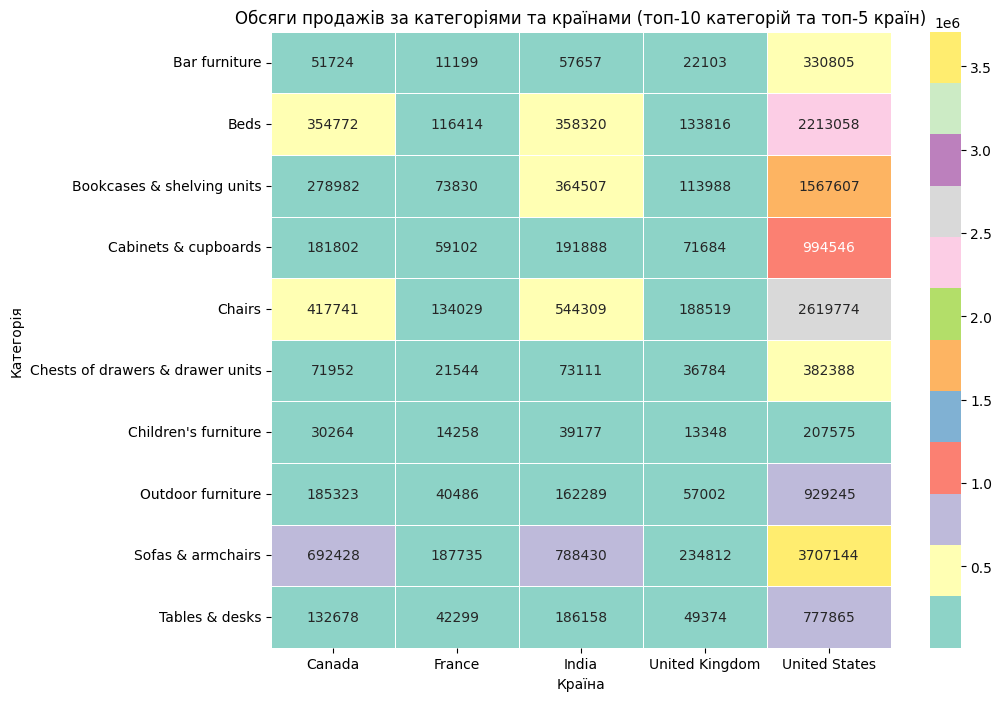

In [ ]:
# Видаляємо рядки, де відсутні дані про категорію, країну або продажі
df_filtered = df.dropna(subset=["category", "country", "price"])

# Обчислюємо топ-10 категорій за обсягом продажів
top_categories = df_filtered.groupby("category")["price"].sum().nlargest(10).index

# Обчислюємо топ-5 країн за обсягом продажів
top_countries = df_filtered.groupby("country")["price"].sum().nlargest(5).index

# Фільтруємо датафрейм за топ-10 категоріями та топ-5 країнами
df_top = df_filtered[df_filtered["category"].isin(top_categories) & df_filtered["country"].isin(top_countries)]

# Створюємо зведену таблицю
pivot_table = df_top.pivot_table(
    index="category",
    columns="country",
    values="price",
    aggfunc="sum",
    fill_value=0
)
# Встановлюємо максимальну ширину виводу для стовпців
pd.set_option("display.expand_frame_repr", False)
# Виводимо результат
print(pivot_table)

# Створюємо теплову карту
plt.figure(figsize=(10, 8))  # Задаємо розмір теплової карти
sns.heatmap(pivot_table, cmap="Set3", annot=True, fmt=".0f", linewidths=.5) #cmap="Pastel1", "vlag", "cubehelix"
plt.title("Обсяги продажів за категоріями та країнами (топ-10 категорій та топ-5 країн)")
plt.xlabel("Країна")
plt.ylabel("Категорія")

plt.show()

###Кількість сесій у розрізі країн і браузерів

In [ ]:
# Створюємо зведену таблицю
sessions_pivot = df.pivot_table(
    index="continent",
    columns="browser",
    values="ga_session_id",
    aggfunc="count",
    fill_value=0
)

# Виводимо результат
print(sessions_pivot)


browser    <Other>  Android Webview  Chrome  Edge  Firefox  Safari
continent                                                         
(not set)       29               12     558    24       17     155
Africa         102               46    2409    99       65     899
Americas      4944             2495  131928  4463     3621   45728
Asia          2130             1042   56522  1935     1519   19965
Europe        1645              819   44442  1424     1145   15660
Oceania         80               31    2601    78       66     847


###Середній чек у розрізі категорій і пристроїв

device                                    desktop       mobile       tablet
category                                                                   
Bar furniture                          668.829721   686.378571   583.076923
Beds                                  1708.848241  1646.089076  1612.550847
Bookcases & shelving units             479.979130   473.538089   468.117722
Cabinets & cupboards                  1001.666788  1006.662162  1201.666667
Café furniture                         386.244131   373.225352   725.000000
Chairs                                1058.552438   984.076257  1186.813139
Chests of drawers & drawer units       627.390898   617.685739   668.259259
Children's furniture                   276.459064   269.895963   319.906250
Nursery furniture                      382.088106   326.308176   373.750000
Outdoor furniture                      958.848387   961.093984  1023.430435
Room dividers                          806.276923   835.441860   978.000000
Sideboards, 

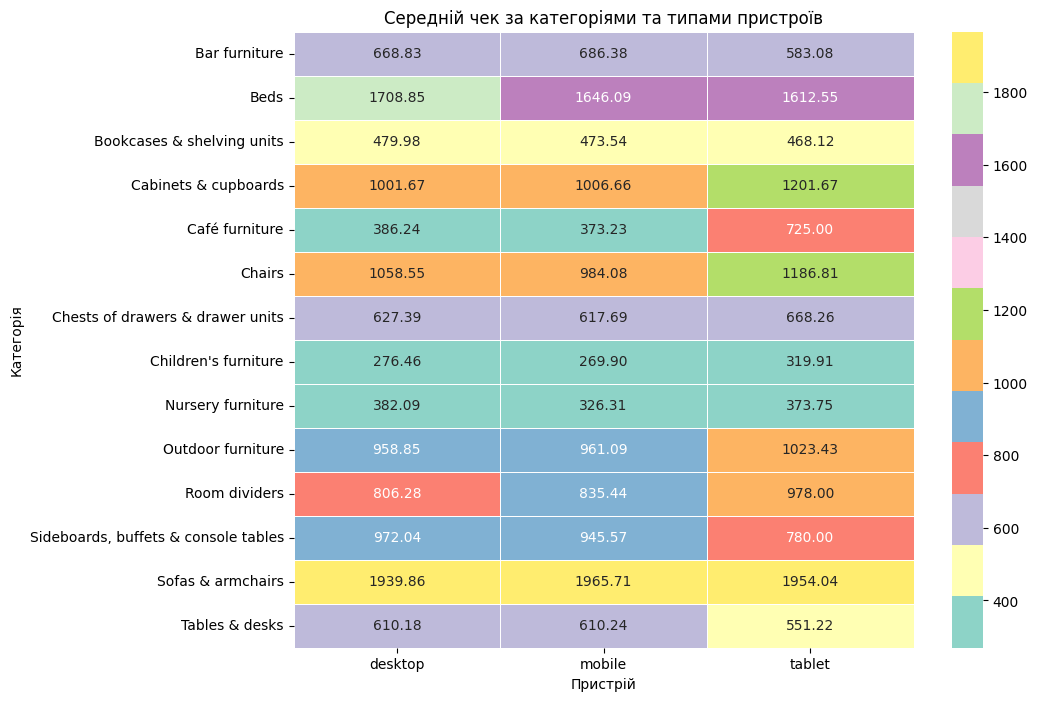

In [ ]:
# Створюємо зведену таблицю для середнього чеку
avg_check_pivot = df.pivot_table(
    index="category",
    columns="device",
    values="price",
    aggfunc="mean",
    fill_value=0
)

# Виводимо результат
print(avg_check_pivot)

# Створюємо теплову карту
plt.figure(figsize=(10, 8))  # Задаємо розмір теплової карти
sns.heatmap(avg_check_pivot, cmap="Set3", annot=True, fmt=".2f", linewidths=.5)
plt.title("Середній чек за категоріями та типами пристроїв")
plt.xlabel("Пристрій")
plt.ylabel("Категорія")
plt.show()


#Статистичний аналіз взаємозв’язків

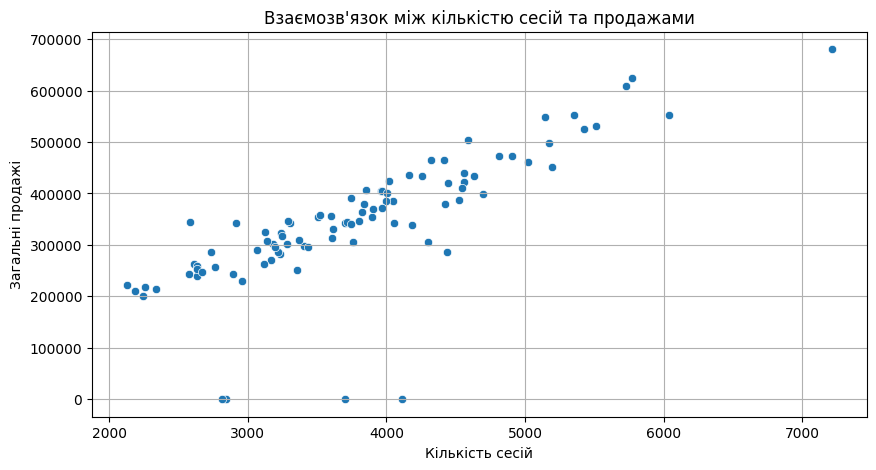

Коефіцієнт кореляції Пірсона: 0.7911
P-value: 0.0000
Кореляція є статистично значущою.


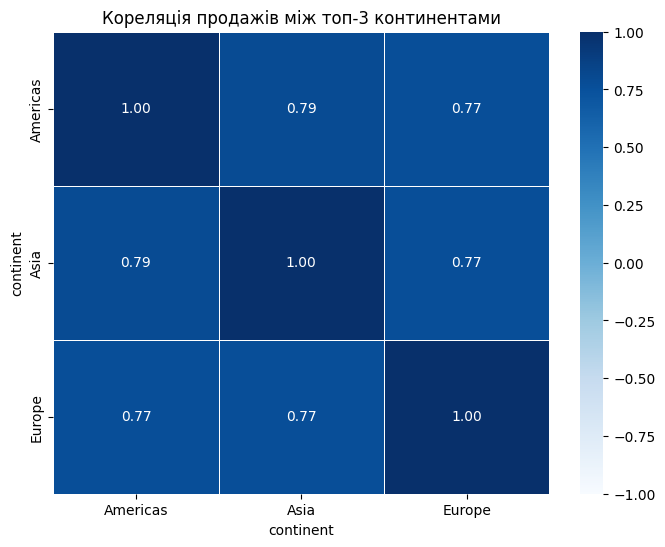

    Група 1 Група 2  Кореляція       p-value  Значуща кореляція
0  Americas    Asia   0.792025  5.409189e-21               True
1  Americas  Europe   0.770586  2.671449e-19               True
2      Asia  Europe   0.768427  3.864946e-19               True


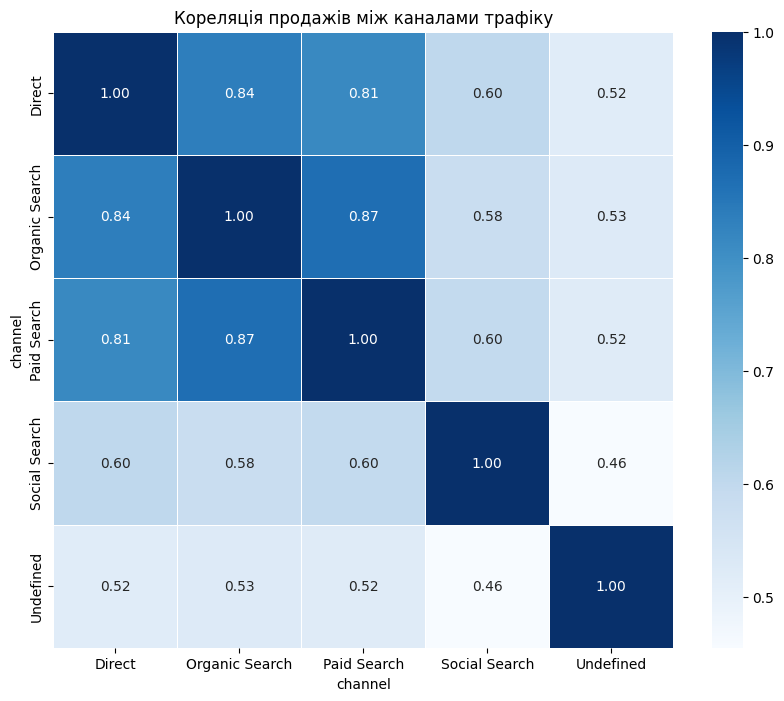

          Група 1         Група 2  Кореляція       p-value  Значуща кореляція
0          Direct  Organic Search   0.837833  2.190420e-25               True
1          Direct     Paid Search   0.814072  5.896435e-23               True
2          Direct   Social Search   0.604060  1.831889e-10               True
3          Direct       Undefined   0.517505  1.275436e-07               True
4  Organic Search     Paid Search   0.870086  2.142003e-29               True
5  Organic Search   Social Search   0.583117  1.066192e-09               True
6  Organic Search       Undefined   0.526068  7.228214e-08               True
7     Paid Search   Social Search   0.596428  3.532284e-10               True
8     Paid Search       Undefined   0.521961  9.509609e-08               True
9   Social Search       Undefined   0.455126  5.161928e-06               True


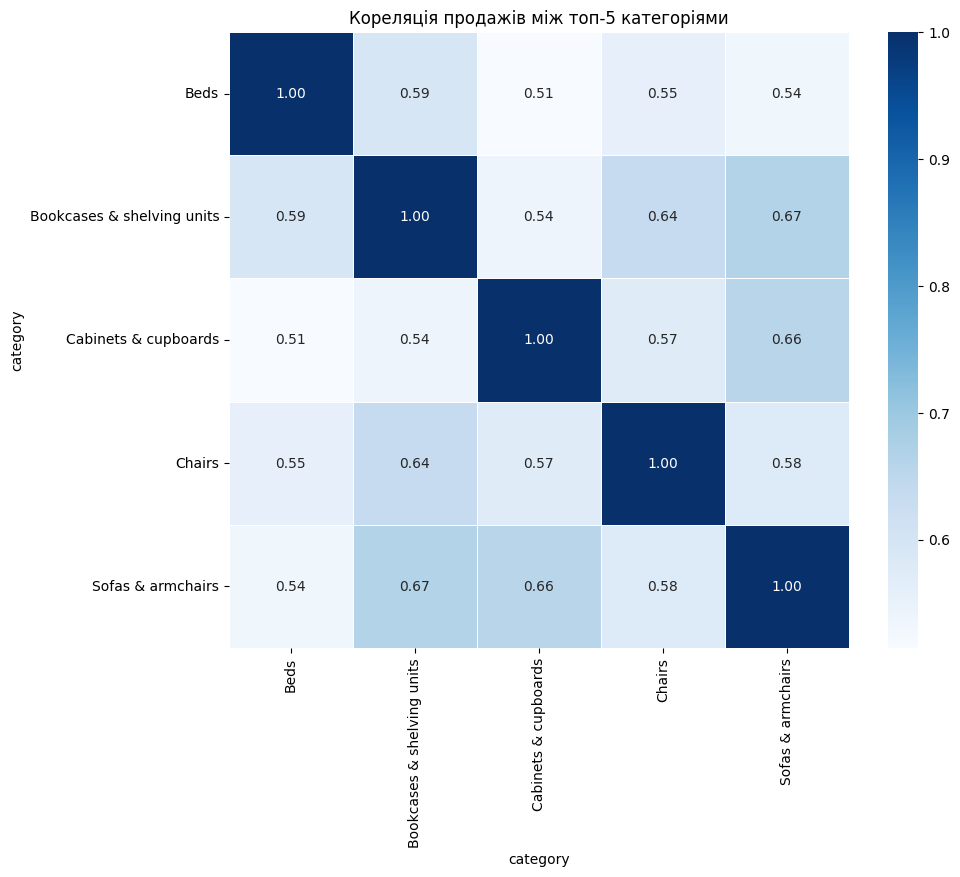

                      Група 1                     Група 2  Кореляція       p-value  Значуща кореляція
0                        Beds  Bookcases & shelving units   0.592913  1.154998e-09               True
1                        Beds        Cabinets & cupboards   0.514609  2.910930e-07               True
2                        Beds                      Chairs   0.554500  2.079183e-08               True
3                        Beds           Sofas & armchairs   0.535378  7.687333e-08               True
4  Bookcases & shelving units        Cabinets & cupboards   0.539428  5.867225e-08               True
5  Bookcases & shelving units                      Chairs   0.637090  2.504550e-11               True
6  Bookcases & shelving units           Sofas & armchairs   0.666194  1.406972e-12               True
7        Cabinets & cupboards                      Chairs   0.572870  5.465903e-09               True
8        Cabinets & cupboards           Sofas & armchairs   0.657563  3.415056e-12

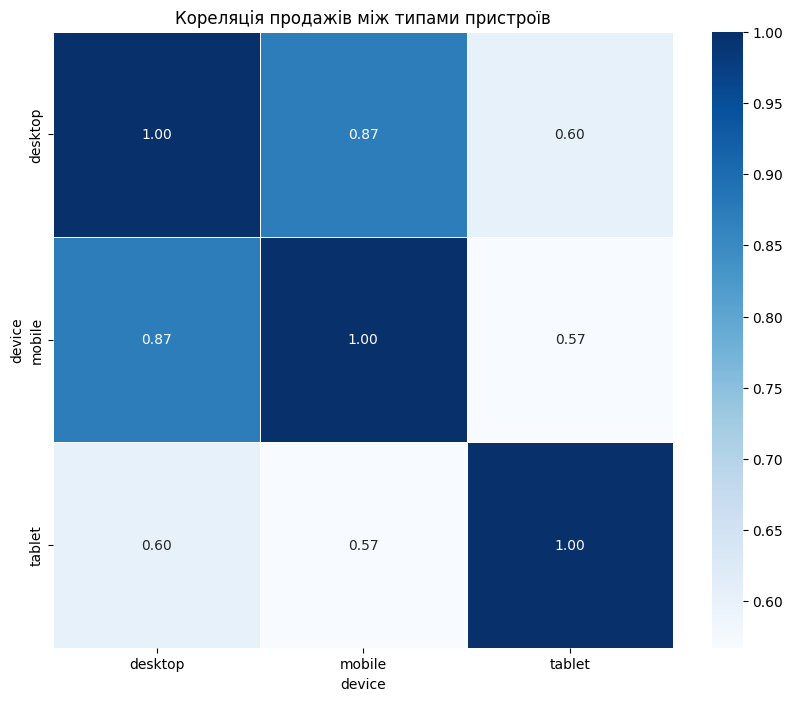

   Група 1 Група 2  Кореляція       p-value  Значуща кореляція
0  desktop  mobile   0.873201  7.719911e-30               True
1  desktop  tablet   0.601354  2.316806e-10               True
2   mobile  tablet   0.567394  3.693817e-09               True


In [ ]:

# 1. Агрегація сесій і продажів за датами
df_agg = df.groupby("date").agg(
    sessions=("ga_session_id", "count"),
    total_sales=("price", "sum")
).reset_index()

# Візуалізація
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_agg, x="sessions", y="total_sales")
plt.xlabel("Кількість сесій")
plt.ylabel("Загальні продажі")
plt.title("Взаємозв'язок між кількістю сесій та продажами")
plt.grid(True)
plt.show()

# Кореляція Пірсона
correlation, p_value = pearsonr(df_agg["sessions"], df_agg["total_sales"])
print(f"Коефіцієнт кореляції Пірсона: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")
print("Кореляція є статистично значущою." if p_value < 0.05 else "Кореляція не є статистично значущою.")

# 2. Продажі за континентами
df_continent_sales = df.groupby(["date", "continent"])["price"].sum().unstack()

top_continents = df.groupby("continent")["price"].sum().nlargest(3).index
df_top_continent_sales = df_continent_sales[top_continents]

# Функція обчислення кореляції
def compute_correlation_matrix(data):
    corr_matrix = data.corr()
    results = []
    for col1, col2 in combinations(data.columns, 2):
        corr, p_value = pearsonr(data[col1], data[col2])
        is_significant = p_value < 0.05
        results.append({"Група 1": col1, "Група 2": col2, "Кореляція": corr, "p-value": p_value, "Значуща кореляція": is_significant})
    return corr_matrix, pd.DataFrame(results)

corr_matrix, df_corr_results = compute_correlation_matrix(df_top_continent_sales)

# Візуалізація кореляційної матриці
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", linewidths=0.5, fmt=".2f", vmin=-1, vmax=1)
plt.title("Кореляція продажів між топ-3 континентами")
plt.show()
print(df_corr_results)

# 3. Кореляція продажів між каналами трафіку
df_sales_by_channel = df.groupby(["date", "channel"])["price"].sum().unstack().fillna(0)
corr_matrix, df_corr_results = compute_correlation_matrix(df_sales_by_channel)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", linewidths=0.5, fmt=".2f")
plt.title("Кореляція продажів між каналами трафіку")
plt.show()
print(df_corr_results)

# 4. Кореляція продажів між топ-5 категоріями
top_categories = df.groupby('category')['price'].sum().nlargest(5).index
df_top = df[df['category'].isin(top_categories)]
sales_by_category = df_top.groupby(['category', 'date'])['price'].sum().unstack(level=0).fillna(0)
corr_matrix, df_corr_results = compute_correlation_matrix(sales_by_category)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', linewidths=0.5, fmt=".2f")
plt.title('Кореляція продажів між топ-5 категоріями')
plt.show()
print(df_corr_results)

# 5. Кореляція продажів між пристроями
df_sales_by_device = df.groupby(['device', 'date'])['price'].sum().unstack(level=0).fillna(0)
corr_matrix, df_corr_results = compute_correlation_matrix(df_sales_by_device)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', linewidths=0.5, fmt=".2f")
plt.title('Кореляція продажів між типами пристроїв')
plt.show()
print(df_corr_results)

#Статистичний аналіз відмінностей між групами

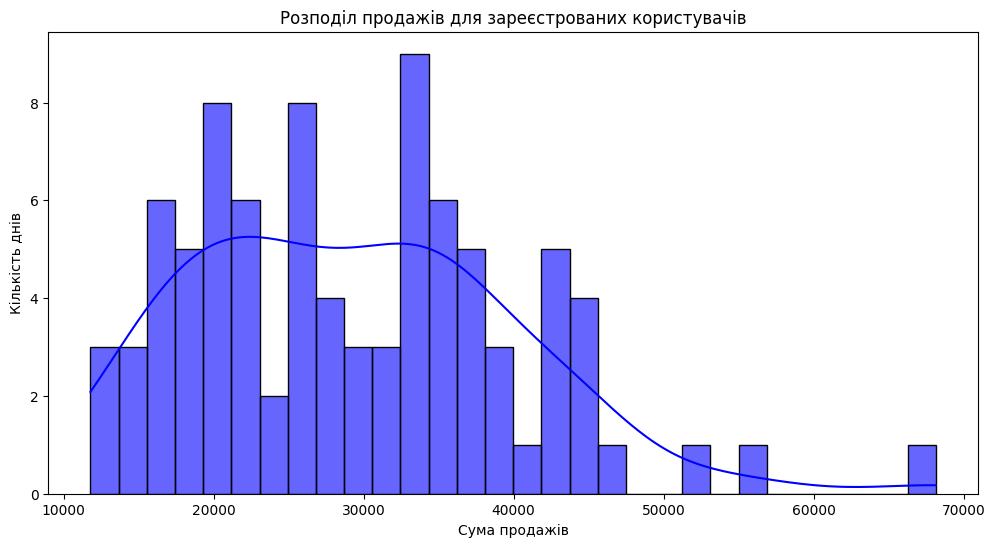

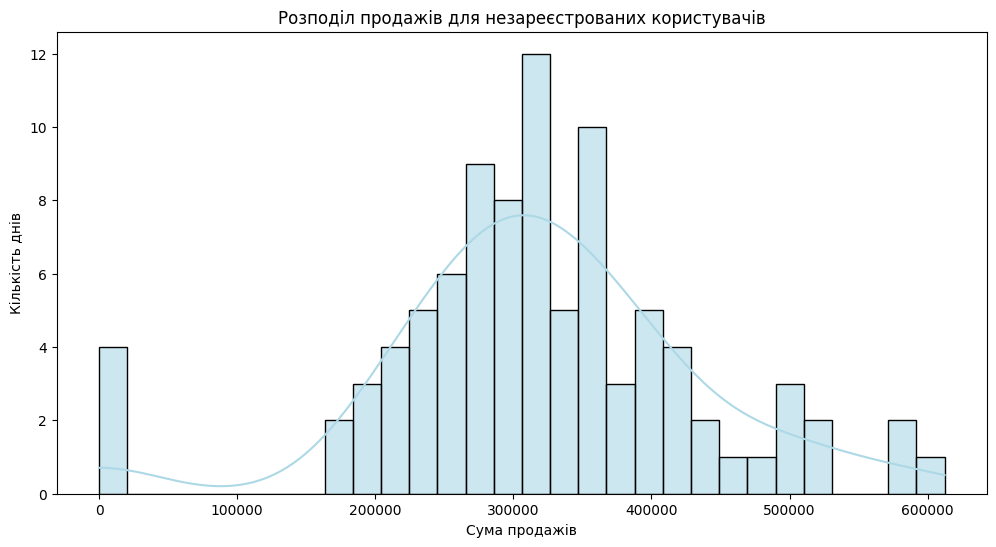

Shapiro-Wilk test (зареєстровані): p-value=0.007295139880540744
Shapiro-Wilk test (незареєстровані): p-value=0.0012184604855253293
Mann-Whitney U test p-value: 3.8805185465235906e-26
Різниця між групами статистично значуща


<ipython-input-30-c0d8e517ef52>:50: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




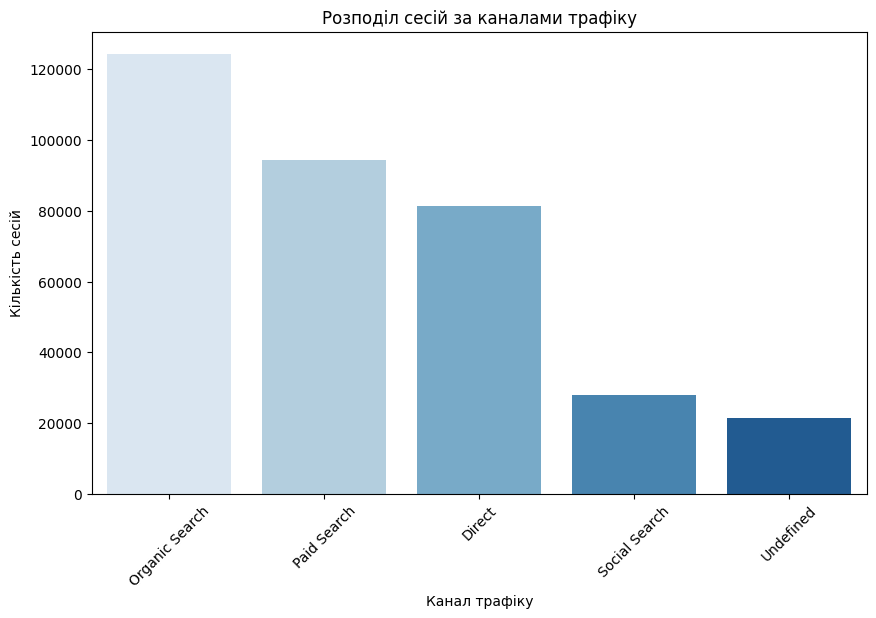

Хі-квадрат статистика: 20.296184523451902, p-значення: 0.43954438481889735
Немає статистично значущої різниці


<ipython-input-30-c0d8e517ef52>:75: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




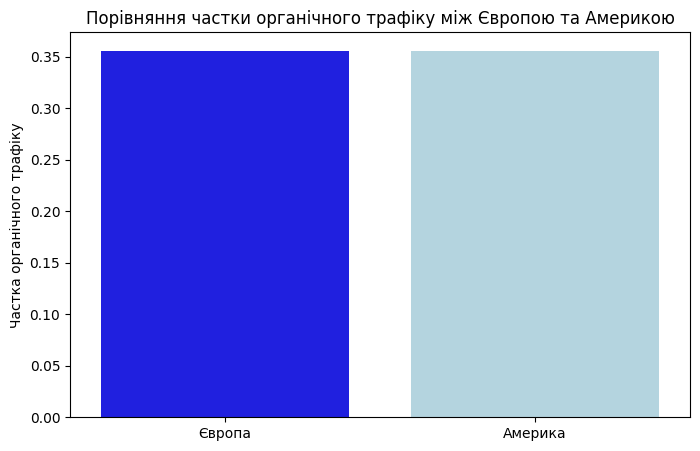

Європа: 23195/65135 (p1 = 0.3561)
Америка: 68671/193179 (p2 = 0.3555)
Z-статистика: 0.2895, p-значення: 0.7722
Немає статистично значущої різниці


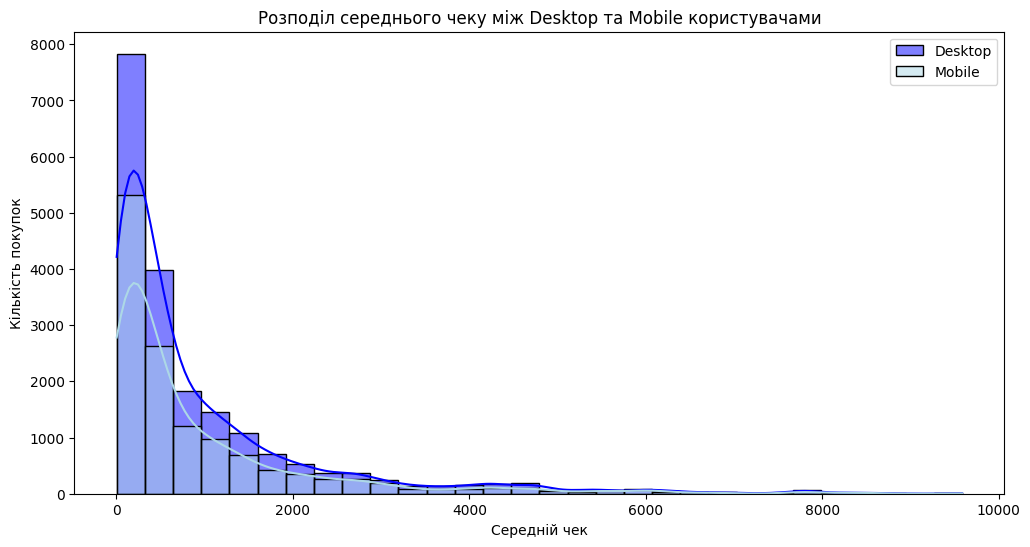

Тест Манна-Уітні для середнього чеку: 130361108.5, p-значення: 0.15860325976935175
Немає статистично значущої різниці


In [ ]:

# Фільтрація основних груп
registered = df[df["account_id"].notna()]
unregistered = df[df["account_id"].isna()]
europe_sessions = df[df["continent"] == "Europe"]
americas_sessions = df[df["continent"] == "Americas"]
desktop_sales = df[df["device"] == "desktop"]["price"].dropna()
mobile_sales = df[df["device"] == "mobile"]["price"].dropna()

# Групування продажів для зареєстрованих/незареєстрованих користувачів
registered_sales = registered.groupby("date")["price"].sum().reset_index()
unregistered_sales = unregistered.groupby("date")["price"].sum().reset_index()

# Функція для побудови гістограми
def plot_histogram(data, title, color):
    plt.figure(figsize=(12, 6))
    sns.histplot(data, kde=True, color=color, bins=30, alpha=0.6)
    plt.title(title)
    plt.xlabel("Сума продажів")
    plt.ylabel("Кількість днів")
    plt.show()

# Візуалізація розподілу продажів
plot_histogram(registered_sales["price"], "Розподіл продажів для зареєстрованих користувачів", "blue")
plot_histogram(unregistered_sales["price"], "Розподіл продажів для незареєстрованих користувачів", "lightblue")

# Функція для перевірки нормальності
def check_normality(data, label):
    stat, p_value = shapiro(data)
    print(f"Shapiro-Wilk test ({label}): p-value={p_value}")
    return p_value > 0.05  # True, якщо розподіл нормальний

normal_reg = check_normality(registered_sales["price"], "зареєстровані")
normal_unreg = check_normality(unregistered_sales["price"], "незареєстровані")

# Вибір статистичного тесту
if normal_reg and normal_unreg:
    test_stat, p_value = ttest_ind(registered_sales["price"], unregistered_sales["price"], equal_var=False)
    test_name = "T-test"
else:
    test_stat, p_value = mannwhitneyu(registered_sales["price"], unregistered_sales["price"], alternative='two-sided')
    test_name = "Mann-Whitney U test"

print(f"{test_name} p-value: {p_value}")
print("Різниця між групами статистично значуща" if p_value < 0.05 else "Немає статистично значущої різниці")

# Аналіз каналів трафіку
channel_counts = df["channel"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=channel_counts.index, y=channel_counts.values, palette="Blues")
plt.xlabel("Канал трафіку")
plt.ylabel("Кількість сесій")
plt.title("Розподіл сесій за каналами трафіку")
plt.xticks(rotation=45)
plt.show()

# Хі-квадрат тест
contingency_table = pd.crosstab(df["continent"], df["channel"])
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Хі-квадрат статистика: {chi2_stat}, p-значення: {p_value}")
print("Є статистично значуща різниця між каналами трафіку" if p_value < 0.05 else "Немає статистично значущої різниці")

# Z-тест для Європи та Америки
X1, X2 = (europe_sessions["channel"] == "Organic Search").sum(), (americas_sessions["channel"] == "Organic Search").sum()
n1, n2 = len(europe_sessions), len(americas_sessions)

stat, p_value = proportions_ztest([X1, X2], [n1, n2], alternative='two-sided')

# Візуалізація порівняння частки органічного трафіку
labels = ["Європа", "Америка"]
values = [X1 / n1, X2 / n2]

plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=values, palette=["blue", "lightblue"])
plt.ylabel("Частка органічного трафіку")
plt.title("Порівняння частки органічного трафіку між Європою та Америкою")
plt.show()

print(f"Європа: {X1}/{n1} (p1 = {X1/n1:.4f})")
print(f"Америка: {X2}/{n2} (p2 = {X2/n2:.4f})")
print(f"Z-статистика: {stat:.4f}, p-значення: {p_value:.4f}")
print("Є статистично значуща різниця у частках органічного трафіку" if p_value < 0.05 else "Немає статистично значущої різниці")

# Аналіз середнього чеку між desktop та mobile користувачами
plt.figure(figsize=(12, 6))
sns.histplot(desktop_sales, label="Desktop", kde=True, bins=30, color='blue')
sns.histplot(mobile_sales, label="Mobile", kde=True, bins=30, color='lightblue')
plt.xlabel("Середній чек")
plt.ylabel("Кількість покупок")
plt.title("Розподіл середнього чеку між Desktop та Mobile користувачами")
plt.legend()
plt.show()

# Тест Манна-Уітні
stat_check, p_value_check = mannwhitneyu(desktop_sales, mobile_sales, alternative='two-sided')

print(f"Тест Манна-Уітні для середнього чеку: {stat_check}, p-значення: {p_value_check}")
print("Є статистично значуща різниця у середньому чеку" if p_value_check < 0.05 else "Немає статистично значущої різниці")


###Посилання на дашборд: https://public.tableau.com/app/profile/svitlana.kopach/viz/AnalyticalDashboard_17403259864180/Dashboard1